In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
from shapely.geometry import Polygon, Point, MultiPolygon

In [2]:
iron = Polygon([[32, 68], [32, 96], [96, 96], [96, 32], [32, 32], [32, 60], [40, 60], [40, 40], [88, 40], [88, 88], [40, 88], [40, 68]])
wire = Polygon([[82, 63], [82, 64], [83, 64], [83, 63]])
combined = MultiPolygon([iron, wire])

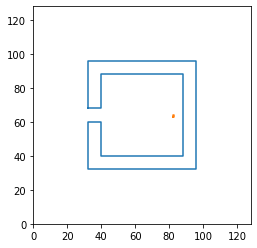

In [3]:
x,y = iron.exterior.xy
plt.plot(x,y)
x,y = wire.exterior.xy
plt.plot(x,y)
plt.xlim(0, 128)
plt.ylim(0, 128)
plt.gca().set_aspect('equal', adjustable='box')



In [4]:
class MultiResolutionHashEncoding(torch.nn.Module):
    def __init__(self, image_size, L, F, T):
        super().__init__()
        self.image_size = image_size
        self.L = L
        self.F = F
        self.T = T
        self.feature_matrix = torch.nn.Parameter(torch.randn((self.T, self.F)))

    def hash_function(self,x): #input: coordinates
        x1, x2 = x
        pi1 = 1
        pi2 = 805459861
        return ((int(x1)*pi1)^(int(x2)*pi2))%self.T

    def distance(self,x1, x2):
        return np.sqrt(np.sum(np.square(x1-x2)))

    def forward(self, x):
        output_tensor = torch.zeros(self.L*self.F, 0)
        for i in range(x.shape[0]):
            x1, x2 = x[i,:]
            full_feature = torch.zeros(0, 1)
            for l in range(self.L):
                tile_size = self.image_size/(2**(l+1))
                x1_floor = x1//tile_size
                x2_floor = x2//tile_size

                corner1 = (x1_floor*tile_size, x2_floor*tile_size)
                corner2 = (x1_floor*tile_size, (x2_floor+1)*tile_size)
                corner3 = ((x1_floor+1)*tile_size, x2_floor*tile_size)
                corner4 = ((x1_floor+1)*tile_size, (x2_floor+1)*tile_size)

                distance1 = self.distance(x, np.array(corner1))
                distance2 = self.distance(x, np.array(corner2))
                distance3 = self.distance(x, np.array(corner3))
                distance4 = self.distance(x, np.array(corner4))

                w1 = distance1/(distance1+distance2+distance3+distance4)
                w2 = distance2/(distance1+distance2+distance3+distance4)
                w3 = distance3/(distance1+distance2+distance3+distance4)
                w4 = distance4/(distance1+distance2+distance3+distance4)

                corner1_feature = self.feature_matrix[self.hash_function(corner1),:]
                corner2_feature = self.feature_matrix[self.hash_function(corner2),:]
                corner3_feature = self.feature_matrix[self.hash_function(corner3),:]
                corner4_feature = self.feature_matrix[self.hash_function(corner4),:]

                weighted_feature = w1*corner1_feature + w2*corner2_feature + w3*corner3_feature + w4*corner4_feature
                full_feature = torch.concat([full_feature, weighted_feature[:,None]])
            output_tensor = torch.concat([output_tensor, full_feature],1)
        return torch.transpose(output_tensor, 0, 1)



In [5]:
class EMNet(nn.Module):
    def __init__(self, image_size, L, F, T):
        super(EMNet, self).__init__()
        self.encoding = MultiResolutionHashEncoding(image_size, L, F, T)
        self.fc1 = nn.Linear(L*F, 64)
        self.fc2 = nn.Linear(64, 2) #B_x and B_y

    def forward(self, x):
        x = self.encoding(x)
        x = self.fc1(x)
        x = functional.relu(x)
        x = self.fc2(x)
        output = functional.relu(x)
        return output

In [6]:
def sample_path(image_size=128, n=100): #return a list of coordinates with associated tangent vector and normal vector
    circle_radius_max = image_size/4
    circle_centre_range = image_size/4 
    rectangle_side_length = image_size/4
    rectangle_centre_range = image_size/4
    current_position = (83, 64)
    if np.random.uniform()<0.5: #circle
        circle_radius = circle_radius_max*np.random.uniform()
        circle_centre_x = circle_centre_range*np.random.uniform()
        circle_centre_y = circle_centre_range*np.random.uniform()
        circle_0 = [(np.cos(2*np.pi/n*x)*circle_radius,np.sin(2*np.pi/n*x)*circle_radius) for x in range(0,n)]
        circle_coordinates = [(x+circle_centre_x+image_size/2, y+circle_centre_y+image_size/2) for (x,y) in circle_0]
        circle_normal = [(x/(np.sqrt(x**2+y**2)), y/(np.sqrt(x**2+y**2))) for (x,y) in circle_0]
        circle_tangent = [(-y/(np.sqrt(x**2+y**2)), x/(np.sqrt(x**2+y**2))) for (x,y) in circle_0]
        if np.sqrt((current_position[0]-circle_centre_x)**2+(current_position[1]-circle_centre_y)**2) <= circle_radius:
            j=1
        else:
            j=0
        return (np.array(circle_coordinates), np.array(circle_normal), np.array(circle_tangent), j, np.array([iron.contains(Point([x, y])) for (x,y) in circle_coordinates]))
    else: #rectangle
        rectangle_x_length = rectangle_side_length*np.random.uniform()
        rectangle_y_length = rectangle_side_length*np.random.uniform()
        rectangle_centre_x = rectangle_centre_range*np.random.uniform()
        rectangle_centre_y = rectangle_centre_range*np.random.uniform()
        corner1 = (image_size/2+rectangle_centre_x+rectangle_x_length/2, image_size/2+rectangle_centre_y+rectangle_y_length/2)
        corner2 = (image_size/2+rectangle_centre_x-rectangle_x_length/2, image_size/2+rectangle_centre_y+rectangle_y_length/2)
        corner3 = (image_size/2+rectangle_centre_x-rectangle_x_length/2, image_size/2+rectangle_centre_y-rectangle_y_length/2)
        corner4 = (image_size/2+rectangle_centre_x+rectangle_x_length/2, image_size/2+rectangle_centre_y-rectangle_y_length/2)
        side1 = [(x, corner1[1]) for x in np.linspace(corner1[0],corner2[0] ,int(n/4))]
        side2 = [(corner2[0], x) for x in np.linspace(corner2[1],corner3[1] ,int(n/4))]
        side3 = [(x, corner3[1]) for x in np.linspace(corner3[0],corner4[0] ,int(n/4))]
        side4 = [(corner4[0], x) for x in np.linspace(corner4[1],corner1[1] ,int(n/4))]
        rectangle_coordinates = side1+side2+side3+side4
        rectangle_normal = [(0,1)]*int(n/4)+[(-1,0)]*int(n/4)+[(0,-1)]*int(n/4)+[(1,0)]*int(n/4)
        rectangle_tangent = [(-1,0)]*int(n/4)+[(0,-1)]*int(n/4)+[(1,0)]*int(n/4)+[(0,1)]*int(n/4)
        if current_position[0] < corner1[0] and current_position[0] > corner2[0] and current_position[1] < corner1[1] and current_position[1] > corner4[1]:
            j=1
        else:
            j=0
        return (np.array(rectangle_coordinates), np.array(rectangle_normal), np.array(rectangle_tangent), j, np.array([iron.contains(Point([x, y])) for (x,y) in rectangle_coordinates]))
        

In [7]:
mu_air = 1e-6
mu_iron_low  = 1
mu_iron_high = 20

def loss_func(path, pred):
    coordinates = path[0]
    normal_vecs = torch.from_numpy(path[1])
    tangent_vecs = torch.from_numpy(path[2])
    j = path[3]
    material = path[4]

    mu_vecs = np.array([mu_air if m else mu_iron_low for m in material])
    B_threshold = (max(np.sqrt(np.sum(np.square(pred.detach().numpy()),0)))-min(np.sqrt(np.sum(np.square(pred.detach().numpy()),0))))/2
    B_filter = np.apply_along_axis(lambda x: x>B_threshold, 0, np.sqrt(np.sum(np.square(pred.detach().numpy()),1)))
    mu_vecs = torch.from_numpy(np.where(B_filter, mu_vecs*mu_iron_high/mu_iron_low, mu_vecs))

    loss1 = torch.sum(torch.mul(pred, normal_vecs))
    loss2 = torch.sum(torch.div(torch.sum(torch.mul(pred, tangent_vecs),1), mu_vecs))
    loss2 = loss2-1 if j else loss2
    return loss1+loss2

In [8]:
image_size = 128
L = int(np.log2(128)) #64, 32, 16, 8, 4, 2, 1
F = 2
T = 2**12
lr = 0.5  # learning rate

model = EMNet(image_size, L,F,T)
opt = optim.SGD(model.parameters(), lr=lr)

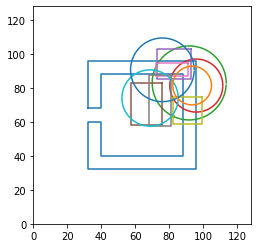

In [42]:
x,y = iron.exterior.xy
plt.plot(x,y)
x,y = wire.exterior.xy
plt.plot(x,y)
plt.xlim(0, 128)
plt.ylim(0, 128)
plt.gca().set_aspect('equal', adjustable='box')
for _ in range(10):
    path = sample_path()
    pred = model(path[0])
    loss = loss_func(path, pred)
    loss.backward()
    opt.step()
    opt.zero_grad()
    plt.plot(path[0][:,0], path[0][:,1])
    print(loss.detach().numpy(), end='\r')
plt.show()

